In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import confusion_matrix

import random

import os, shutil

Data directories

In [6]:
base = "../input/skin-disease-dataset/dataset_skin"

training_dir = os.path.join(base, "training")
validation_dir = os.path.join(base, "validation")

healthy_training_dir = os.path.join(training_dir, "healthy")
healthy_validation_dir = os.path.join(validation_dir, "healthy")

mild_training_dir = os.path.join(training_dir, "mild")
mild_validation_dir = os.path.join(validation_dir, "mild")

moderate_training_dir = os.path.join(training_dir, "moderate")
moderate_validation_dir = os.path.join(validation_dir, "moderate")

severe_training_dir = os.path.join(training_dir, "severe")
severe_validation_dir = os.path.join(validation_dir, "severe")

Make dataset for training and validation

In [7]:
base_dir = "/content/drive/MyDrive/assignment acne severity classification"
base = os.path.join(base_dir, "dataset")
# os.mkdir(base)
training_dir = os.path.join(base, "training")
# os.mkdir(training_dir)
validation_dir = os.path.join(base, "validation")
# os.mkdir(validation_dir)
healthy_training_dir = os.path.join(training_dir, "healthy")
healthy_validation_dir = os.path.join(validation_dir, "healthy")

# os.mkdir(healthy_training_dir)
# os.mkdir(healthy_validation_dir)

mild_training_dir = os.path.join(training_dir, "mild")
mild_validation_dir = os.path.join(validation_dir, "mild")

# os.mkdir(mild_training_dir)
# os.mkdir(mild_validation_dir)

moderate_training_dir = os.path.join(training_dir, "moderate")
moderate_validation_dir = os.path.join(validation_dir, "moderate")

# os.mkdir(moderate_training_dir)
# os.mkdir(moderate_validation_dir)

severe_training_dir = os.path.join(training_dir, "severe")
severe_validation_dir = os.path.join(validation_dir, "severe")

# os.mkdir(severe_training_dir)
# os.mkdir(severe_validation_dir)

Data prepatation

**Note**: instead of augmenting the entire dataset to 4000 images (for each class), we will first define the data augmentation function then perform data splitting for training and validation and only apply the augmentation on the training set. Since the splitting is done randomly, it's important to make sure that none of the augmented images used from training figure in the validation in order to avoid the model from overtting on the entire dataset. 

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=30) 

In [ ]:
def augment_data(data_dir, save_dir, nbr_pictures):
  """
    Augment images by applying random horizontal flip and rotations.

    Args:
    data_dir (string):  path containing the images we want to augment
    save_dir (string):  path in which to save the new images
    nbr_pictures (int): number of new images to generate per image
  """
  for f in os.listdir(data_dir):
    img = load_img(os.path.join(data_dir, f))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir, save_prefix=f'augmented{random.randrange(1, 10**8):08}', save_format="jpg"):
        i += 1
        if( i == nbr_pictures):
            break

Split data

We'll be using 82.5% of the data for training and the rest for validation.
For each class, 330 images will be used for training and 70 for validation. The 330 training images will be augmented to 1980 by generating 5 more images from each image (plus the original image). After augmentation, our dataset will comprise of 2050 images for each class.

In [ ]:
random.seed(12)

def split_data(main_dir, training_dir, validation_dir, train_size):
    """
    Splits the data into train and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split_train = int(train_size * len(shuffled_files)) #the training split casted into int for numeric rounding
    
    train = shuffled_files[:split_train] #training split
    validation = shuffled_files[split_train:] # validation split

    for element in train:
        shutil.copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        shutil.copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory

In [ ]:
split_data(healthy_data, healthy_training_dir, healthy_validation_dir, .825)
split_data(mild_data, mild_training_dir, mild_validation_dir, .825)
split_data(moderate_data, moderate_training_dir, moderate_validation_dir, .825)
split_data(severe_data, severe_training_dir, severe_validation_dir, .825)

Data augmentation

In [ ]:
augment_data(healthy_training_dir, healthy_training_dir, 5)
augment_data(mild_training_dir, mild_training_dir, 5)
augment_data(moderate_training_dir, moderate_training_dir, 5)
augment_data(severe_training_dir, severe_training_dir, 5)

Classification

In [9]:
train_gen = ImageDataGenerator(
    rescale=1./255
)

validation_gen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_gen.flow_from_directory(
        training_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_gen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 7919 images belonging to 4 classes.
Found 280 images belonging to 4 classes.


In [ ]:
image_input = Input(shape=(224, 224, 3))
model = VGG16(weights='imagenet',include_top=False,input_tensor=image_input)
# model.summary()

In [ ]:
x = model.output
x = Flatten()(x)
x = Dense(512)(x)
x = Dense(512)(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x) 
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
# for layer in model.layers[:]:
#     layer.trainable = False
# for layer in model.layers[:15]:
#     layer.trainable = False
# for layer in model.layers[15:]:
#     layer.trainable = True

In [ ]:
opt = Adam(learning_rate=1e-4)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
history = model.fit(
            train_generator,
            epochs=10,
            validation_data=validation_generator)

Epoch 1/10
248/248 [==============================] - 55s 214ms/step - loss: 1.3112 - accuracy: 0.3377 - val_loss: 1.0342 - val_accuracy: 0.4179
Epoch 2/10
248/248 [==============================] - 52s 210ms/step - loss: 0.6234 - accuracy: 0.6904 - val_loss: 0.4871 - val_accuracy: 0.7429
Epoch 3/10
248/248 [==============================] - 52s 210ms/step - loss: 0.3577 - accuracy: 0.8249 - val_loss: 0.3021 - val_accuracy: 0.8429
Epoch 4/10
248/248 [==============================] - 52s 211ms/step - loss: 0.2915 - accuracy: 0.8697 - val_loss: 0.2885 - val_accuracy: 0.8714
Epoch 5/10
248/248 [==============================] - 52s 211ms/step - loss: 0.2399 - accuracy: 0.8978 - val_loss: 0.2760 - val_accuracy: 0.8893
Epoch 6/10
248/248 [==============================] - 53s 212ms/step - loss: 0.2077 - accuracy: 0.9122 - val_loss: 0.2369 - val_accuracy: 0.8964
Epoch 7/10
248/248 [==============================] - 52s 211ms/step - loss: 0.1695 - accuracy: 0.9284 - val_loss: 0.3259 - val_ac

<function matplotlib.pyplot.legend(*args, **kwargs)>

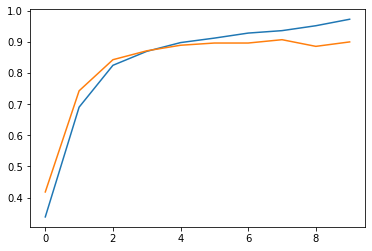

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend

<function matplotlib.pyplot.legend(*args, **kwargs)>

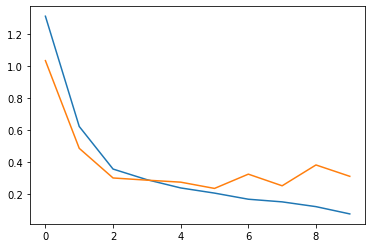

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend

In [ ]:
model.save("/kaggle/working/model/skin_disease_model.h5")

Test images

In [37]:
categories = validation_generator.class_indices
print(categories)
categories = ["healthy", "mild", "moderate", "severe"]

{'healthy': 0, 'mild': 1, 'moderate': 2, 'severe': 3}


1/1 [==============================] - 1s 541ms/step


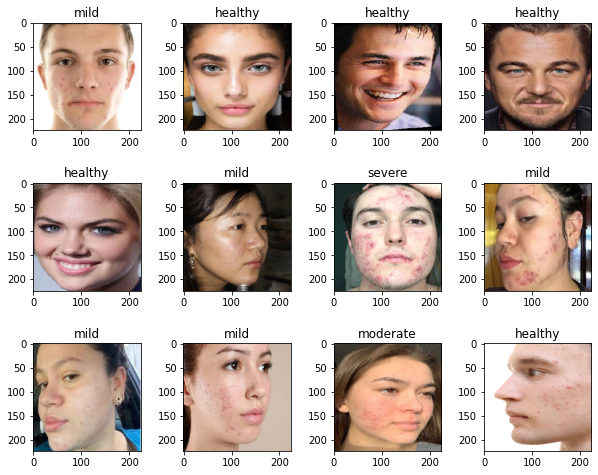

In [45]:
test_path = "../input/skin-disease-dataset/dataset_skin/test_images"
test_images = os.listdir(test_path)
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, image in enumerate(test_images):
    img = load_img(os.path.join(test_path, image), target_size = (224, 224))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    prediction = model.predict(x)
    ax = fig.add_subplot(3, 4, i+1)
    ax.imshow(img)
    ax.set_title(categories[np.argmax(prediction)])
plt.show()